In [1]:
# =============================================================================
# BRAIN TUMOR CLASSIFICATION WITH DEEP LEARNING
# Akbank Derin Öğrenme Bootcamp Projesi
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("✅ Tüm kütüphaneler başarıyla yüklendi!")
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


2025-09-26 14:19:43.715836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758896384.082480      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758896384.175600      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Tüm kütüphaneler başarıyla yüklendi!
TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# =============================================================================
# VERİ SETİ KEŞFÎ VE ANALİZİ
# =============================================================================

# Dataset  tanımlama
DATASET_PATH = "/kaggle/input/brain-tumor-mri-dataset"
TRAINING_PATH = f"{DATASET_PATH}/Training"
TESTING_PATH = f"{DATASET_PATH}/Testing"


CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']
CLASS_LABELS = {
    'glioma': 'Glioma (Gliom)',
    'meningioma': 'Meningioma (Meningiom)', 
    'notumor': 'No Tumor (Tümör Yok)',
    'pituitary': 'Pituitary (Hipofiz)'
}

def analyze_dataset_structure():
    """Dataset yapısını analiz eder ve görselleştirir"""
    
    print("🔍 DATASET YAPISI ANALİZİ")
    print("=" * 50)
    

    train_counts = {}
    test_counts = {}
    
    for class_name in CLASS_NAMES:
        train_path = Path(f"{TRAINING_PATH}/{class_name}")
        test_path = Path(f"{TESTING_PATH}/{class_name}")
        
        train_count = len(list(train_path.glob("*.jpg"))) if train_path.exists() else 0
        test_count = len(list(test_path.glob("*.jpg"))) if test_path.exists() else 0
        
        train_counts[class_name] = train_count
        test_counts[class_name] = test_count
        
        print(f"{CLASS_LABELS[class_name]:<25} | Train: {train_count:>4} | Test: {test_count:>4}")
    

    total_train = sum(train_counts.values())
    total_test = sum(test_counts.values())
    total_images = total_train + total_test
    
    print("-" * 50)
    print(f"{'TOPLAM':<25} | Train: {total_train:>4} | Test: {total_test:>4}")
    print(f"{'GENEL TOPLAM':<25} | {total_images:>4} görüntü")
    
    return train_counts, test_counts

# Dataset analizi
train_counts, test_counts = analyze_dataset_structure()


🔍 DATASET YAPISI ANALİZİ
Glioma (Gliom)            | Train: 1321 | Test:  300
Meningioma (Meningiom)    | Train: 1339 | Test:  306
No Tumor (Tümör Yok)      | Train: 1595 | Test:  405
Pituitary (Hipofiz)       | Train: 1457 | Test:  300
--------------------------------------------------
TOPLAM                    | Train: 5712 | Test: 1311
GENEL TOPLAM              | 7023 görüntü


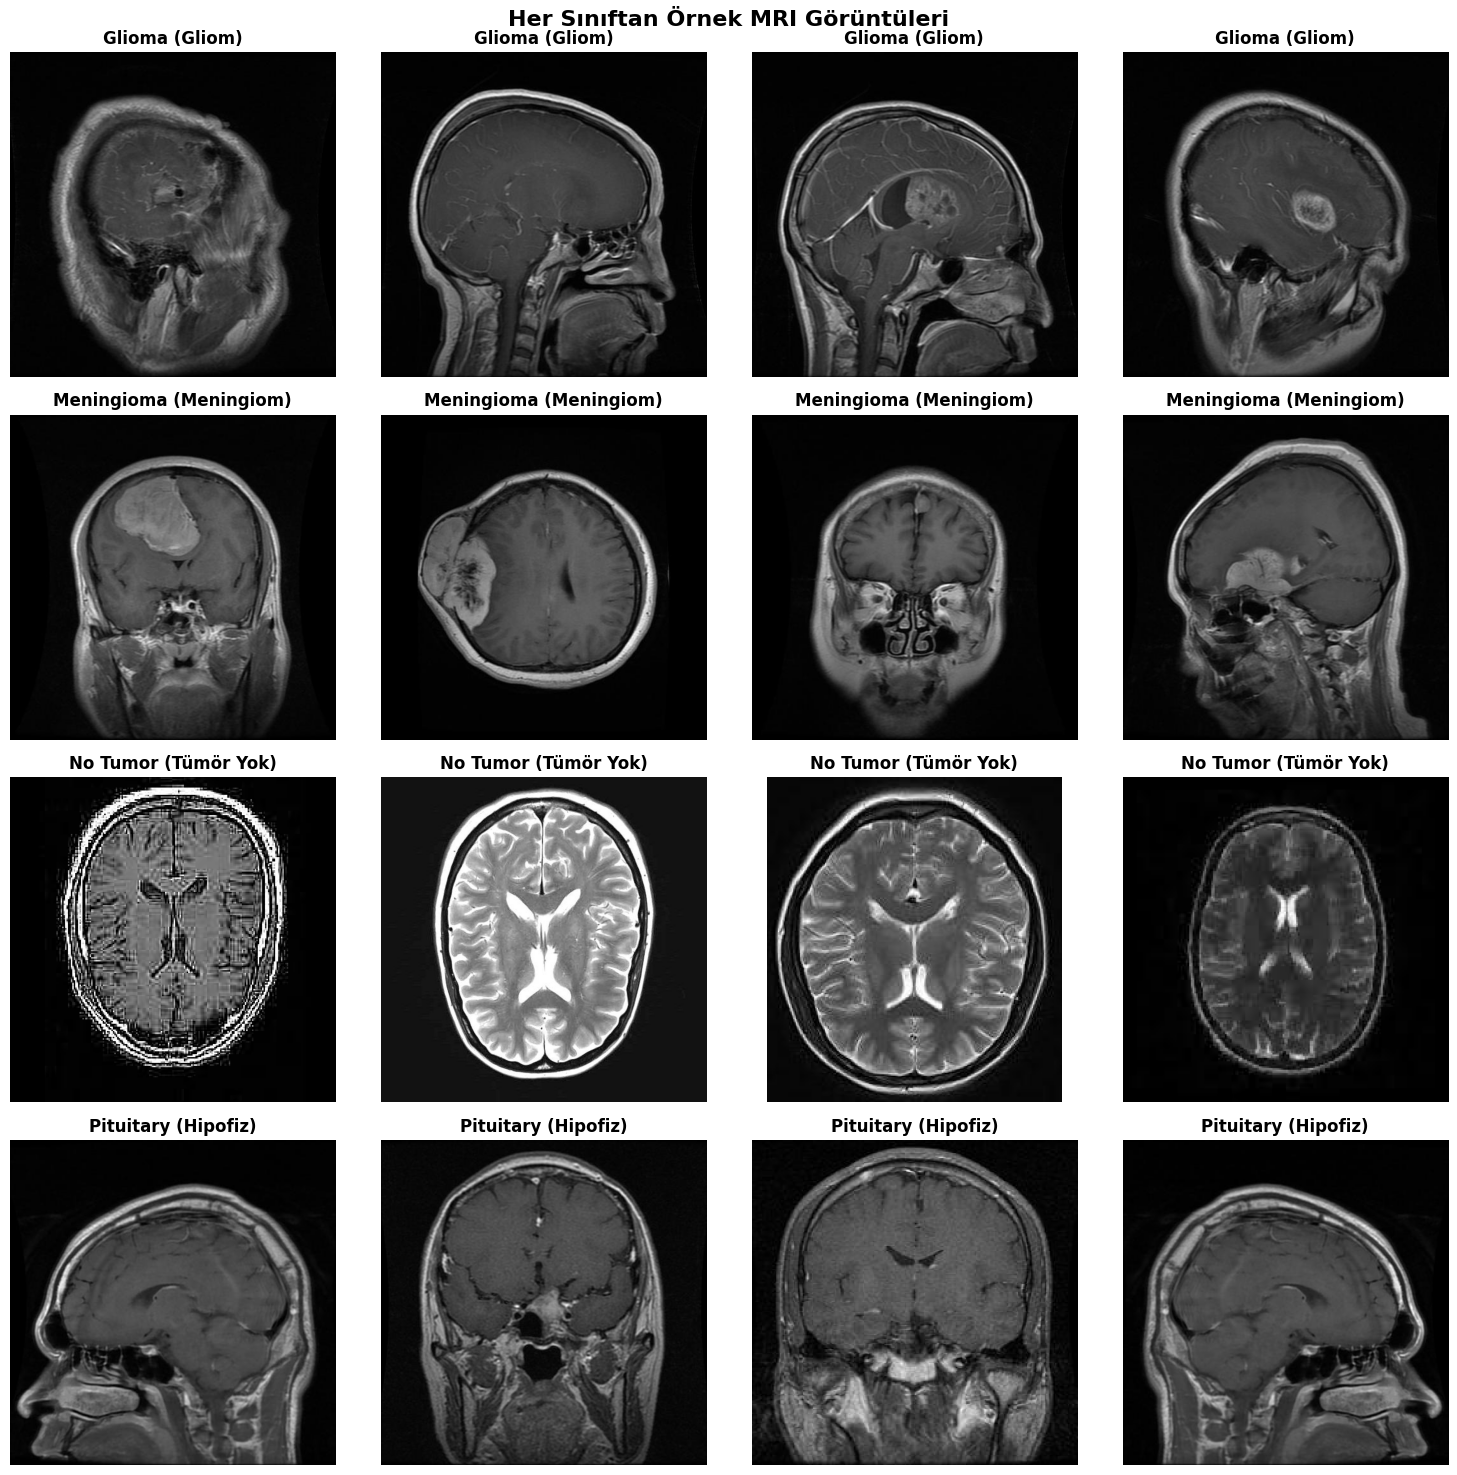

In [3]:
# =============================================================================
# VERİ GÖRSELLEŞTİRME
# =============================================================================

def visualize_dataset_distribution(train_counts, test_counts):
    """Dataset dağılımını görselleştirir"""
    
    # Veri hazırlama
    classes = list(CLASS_LABELS.values())
    train_values = list(train_counts.values())
    test_values = list(test_counts.values())
    
    # Subplot oluşturma
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "bar"}, {"type": "pie"}]],
        subplot_titles=("Sınıf Bazında Dağılım", "Toplam Dağılım")
    )
    
    # Bar chart
    fig.add_trace(
        go.Bar(name="Training", x=classes, y=train_values, marker_color='lightblue'),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(name="Testing", x=classes, y=test_values, marker_color='lightcoral'),
        row=1, col=1
    )
    
    # Pie chart
    total_values = [train_values[i] + test_values[i] for i in range(len(classes))]
    fig.add_trace(
        go.Pie(labels=classes, values=total_values, name="Toplam"),
        row=1, col=2
    )
    
    fig.update_layout(
        title_text="Brain Tumor Dataset Dağılımı",
        showlegend=True,
        height=500
    )
    
    fig.show()

# Görselleştirme
visualize_dataset_distribution(train_counts, test_counts)

def display_sample_images():
    """Her sınıftan örnek görüntüler gösterir"""
    
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    fig.suptitle('Her Sınıftan Örnek MRI Görüntüleri', fontsize=16, fontweight='bold')
    
    for i, class_name in enumerate(CLASS_NAMES):
        class_path = Path(f"{TRAINING_PATH}/{class_name}")
        image_files = list(class_path.glob("*.jpg"))[:4]  # İlk 4 görüntü
        
        for j, img_path in enumerate(image_files):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{CLASS_LABELS[class_name]}", fontweight='bold')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images()


In [4]:
# =================================================================
# # ADIM 3: VERİ ÜRETEÇLERİ 
# =================================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 16


BASE_PATH = '/kaggle/input/brain-tumor-mri-dataset' 

TRAIN_DIR = os.path.join(BASE_PATH, 'Training')
TEST_DIR = os.path.join(BASE_PATH, 'Testing')

# --- Veri Üreteçleri ---
datagen_train_val = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(rescale=1./255)

# --- Üreteçleri Oluştur ---
print("✅ Veri üreteçleri oluşturuluyor...")

train_generator = datagen_train_val.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen_train_val.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = datagen_test.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print("\n✅ Oluşturma tamamlandı! Çıktılar:")
print(f"Eğitim için bulunan örnekler: {train_generator.samples}")
print(f"Doğrulama için bulunan örnekler: {validation_generator.samples}")
print(f"Test için bulunan örnekler: {test_generator.samples}")


✅ Veri üreteçleri oluşturuluyor...
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

✅ Oluşturma tamamlandı! Çıktılar:
Eğitim için bulunan örnekler: 4571
Doğrulama için bulunan örnekler: 1141
Test için bulunan örnekler: 1311


In [5]:
# =================================================================
# # ADIM 4: MODEL MİMARİSİ TASARIMI 
# =================================================================
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
NUM_CLASSES = 4 # Sınıf sayımız (Glioma, Meningioma, No Tumor, Pituitary)

# VGG16 modelini, sonundaki sınıflandırma katmanları olmadan yüklüyoruz.
# Giriş boyutunu kendi resimlerimize göre ayarlıyoruz.
base_model = VGG16(
    weights='imagenet',      
    include_top=False,       
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)
)

# VGG16'nın öğrendiği bilgileri korumak için, katmanlarını tekrar eğitilmekten
# "donduruyoruz". Sadece kendi ekleyeceğimiz katmanlar eğitilecek.
for layer in base_model.layers:
    layer.trainable = False

# --- 3. Kendi Sınıflandırma Katmanlarımızı Ekle ---
# Modelin çıktısını alıp kendi katmanlarımızı zincir gibi ekliyoruz.
x = base_model.output
x = Flatten()(x)                               # VGG16'nın 2D çıktısını tek boyutlu bir vektöre düzleştir.
x = Dense(512, activation='relu')(x)           # 512 nörondan oluşan tam bağlantılı bir katman.
x = Dropout(0.5)(x)                            # Aşırı öğrenmeyi (overfitting) engellemek için nöronların %50'sini rastgele kapat.
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Son katman: Sınıf sayısı kadar nöron ve olasılık çıktısı için softmax.

# --- 4. Giriş ve Çıkışları Birleştirerek Yeni Modeli Oluştur ---
model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. Modeli Derle ---
# Modelin nasıl öğreneceğini (optimizer), hangi hata fonksiyonunu kullanacağını (loss)
# ve hangi başarı metriklerini ölçeceğini belirtiyoruz.
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Doğru Transfer Learning modeli başarıyla oluşturuldu ve derlendi.")
print("Modelin özeti aşağıdadır:")
model.summary()


I0000 00:00:1758896405.578961      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758896405.579666      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Doğru Transfer Learning modeli başarıyla oluşturuldu ve derlendi.
Modelin özeti aşağıdadır:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# =============================================================================
# MODEL DERLEMESİ VE CALLBACK'LER
# =============================================================================

def compile_model(model):
    """Modeli derler ve callback'leri tanımlar"""
    
    # Optimizer
    optimizer = optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )
    
    # Model derleme
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    # Callback'ler
    callbacks = [
        
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        
     
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
      
        ModelCheckpoint(
            'best_brain_tumor_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
    ]
    
    return callbacks

# Model derleme
callbacks = compile_model(model)
print("✅ Model derlendi ve callback'ler tanımlandı!")


✅ Model derlendi ve callback'ler tanımlandı!


In [7]:
# =================================================================
# # MODEL EĞİTİMİ
# =================================================================

def train_model(model, train_gen, val_gen, callbacks, epochs=50):
    """Modeli eğitir ve eğitim geçmişini döndürür"""

    print(f"🚀 MODEL EĞİTİMİ BAŞLIYOR...")
    print("=" * 50)

    # Eğitim başlangıç zamanı
    import time
    start_time = time.time()

    # Model eğitimi
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
      
    )

    # Eğitim süresi
    training_time = time.time() - start_time
    print(f"\n✅ Eğitim tamamlandı! Süre: {training_time/60:.2f} dakika")

    return history


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping: Modelin performansı artmadığında eğitimi erken durdurur
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ModelCheckpoint: Sadece en iyi modeli kaydeder
model_checkpoint = ModelCheckpoint('best_brain_tumor_model.h5', save_best_only=True, monitor='val_loss', verbose=1)

callbacks = [early_stopping, model_checkpoint]


# --- Modeli eğit ---
EPOCHS = 50
history = train_model(model, train_generator, validation_generator, callbacks, EPOCHS)


# --- En iyi modeli yükle ---
# Not: EarlyStopping'de restore_best_weights=True olduğu için bu satır aslında
# gereksiz, model zaten en iyi ağırlıklara sahip. 
model.load_weights('best_brain_tumor_model.h5')
print("\n✅ En iyi model ağırlıkları yüklendi!")


🚀 MODEL EĞİTİMİ BAŞLIYOR...
Epoch 1/50


I0000 00:00:1758896411.712449      88 service.cc:148] XLA service 0x7a016c00f5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758896411.713979      88 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758896411.714005      88 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758896412.202756      88 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/286 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.2656 - loss: 2.3833 - precision: 0.1389 - recall: 0.0781         

I0000 00:00:1758896420.408439      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5762 - loss: 2.3425 - precision: 0.6062 - recall: 0.5234
Epoch 1: val_loss improved from inf to 0.78118, saving model to best_brain_tumor_model.h5
286/286 ━━━━━━━━━━━━━━━━━━━━ 109s 341ms/step - accuracy: 0.5765 - loss: 2.3385 - precision: 0.6066 - recall: 0.5236 - val_accuracy: 0.7029 - val_loss: 0.7812 - val_precision: 0.7671 - val_recall: 0.6091
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7477 - loss: 0.6347 - precision: 0.7988 - recall: 0.6776
Epoch 2: val_loss did not improve from 0.78118
286/286 ━━━━━━━━━━━━━━━━━━━━ 68s 239ms/step - accuracy: 0.7477 - loss: 0.6347 - precision: 0.7988 - recall: 0.6776 - val_accuracy: 0.6731 - val_loss: 0.8307 - val_precision: 0.7155 - val_recall: 0.6415
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7687 - loss: 0.5943 - precision: 0.8180 - recall: 0.7097
Epoch 3: val_loss improved from 0.78118 to 0.76818, saving model to best_brain_tumor_model.h5


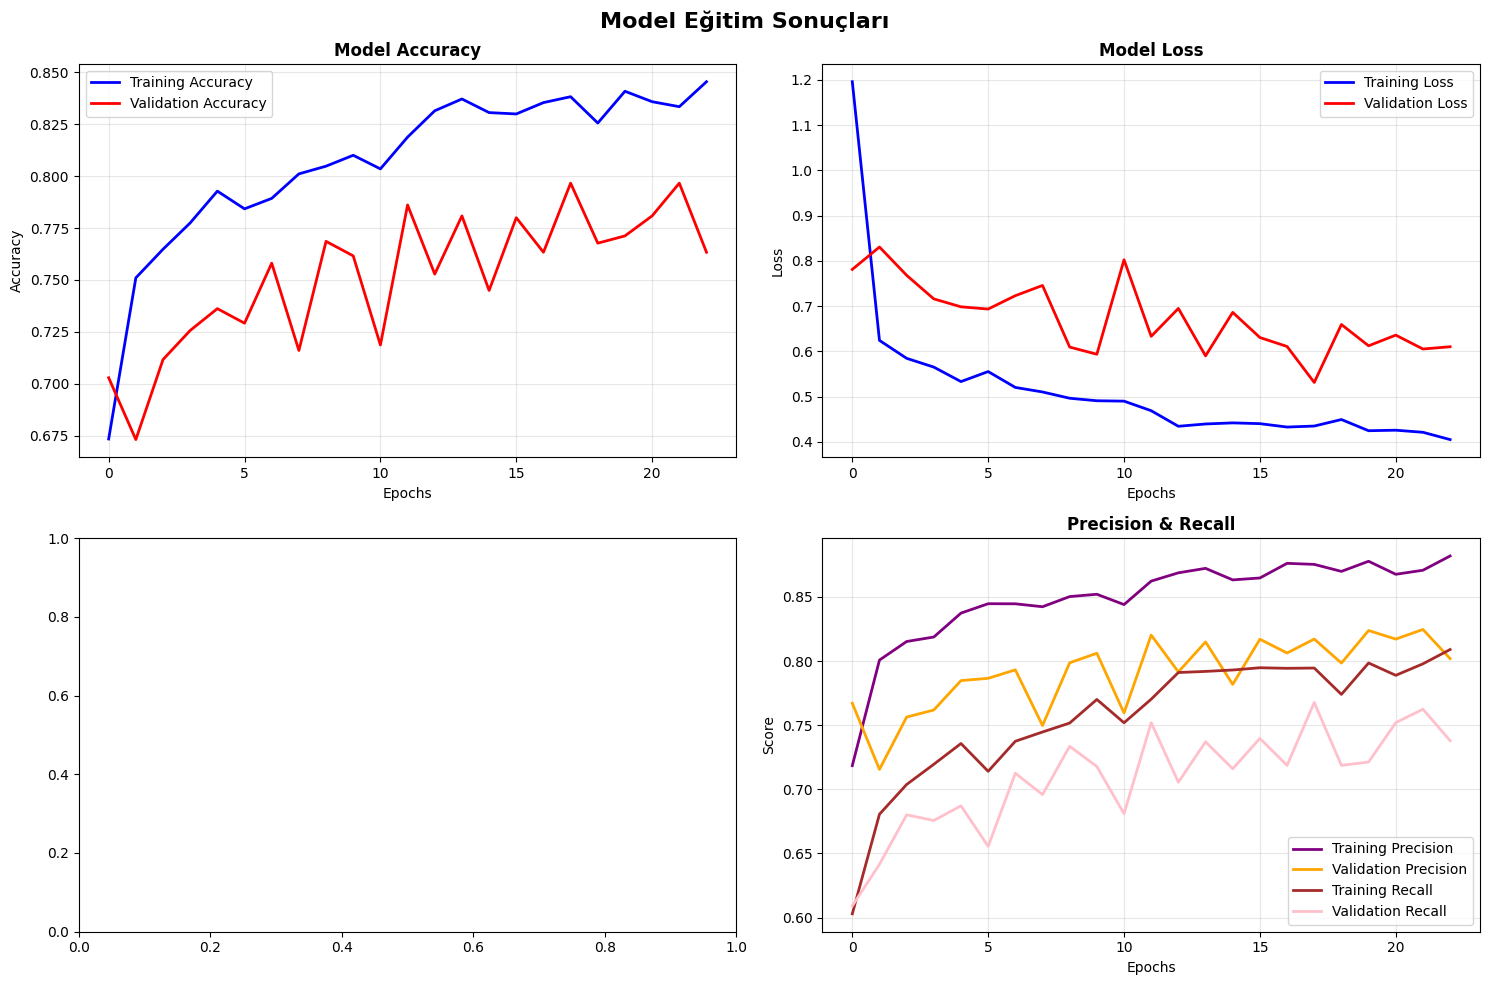


📈 EĞİTİM SONUÇLARI
En İyi Validation Accuracy: 0.7967
En İyi Validation Loss: 0.5314
En İyi Epoch: 18


In [8]:
# =============================================================================
# EĞİTİM SONUÇLARININ GÖRSELLEŞTİRİLMESİ
# =============================================================================

def plot_training_history(history):
    """Eğitim geçmişini görselleştirir"""
    
   
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Eğitim Sonuçları', fontsize=16, fontweight='bold')
    
    # Accuracy plot
    axes[0, 0].plot(epochs_range, acc, label='Training Accuracy', color='blue', linewidth=2)
    axes[0, 0].plot(epochs_range, val_acc, label='Validation Accuracy', color='red', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontweight='bold')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[0, 1].plot(epochs_range, loss, label='Training Loss', color='blue', linewidth=2)
    axes[0, 1].plot(epochs_range, val_loss, label='Validation Loss', color='red', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning rate plot (eğer varsa)
    if 'lr' in history.history:
        axes[1, 0].plot(epochs_range, history.history['lr'], color='green', linewidth=2)
        axes[1, 0].set_title('Learning Rate', fontweight='bold')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Precision ve Recall
    if 'precision' in history.history:
        axes[1, 1].plot(epochs_range, history.history['precision'], label='Training Precision', color='purple', linewidth=2)
        axes[1, 1].plot(epochs_range, history.history['val_precision'], label='Validation Precision', color='orange', linewidth=2)
        axes[1, 1].plot(epochs_range, history.history['recall'], label='Training Recall', color='brown', linewidth=2)
        axes[1, 1].plot(epochs_range, history.history['val_recall'], label='Validation Recall', color='pink', linewidth=2)
        axes[1, 1].set_title('Precision & Recall', fontweight='bold')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # En iyi sonuçları yazdır
    best_val_acc = max(val_acc)
    best_val_loss = min(val_loss)
    best_epoch = val_acc.index(best_val_acc) + 1
    
    print(f"\n📈 EĞİTİM SONUÇLARI")
    print("=" * 40)
    print(f"En İyi Validation Accuracy: {best_val_acc:.4f}")
    print(f"En İyi Validation Loss: {best_val_loss:.4f}")
    print(f"En İyi Epoch: {best_epoch}")

# Eğitim sonuçlarını görselleştir
plot_training_history(history)


In [9]:
# =================================================================
# # MODEL DEĞERLENDİRMESİ 
# =================================================================
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, test_generator):
    print("\n🌀 MODEL DEĞERLENDİRMESİ BAŞLIYOR...")
    print("=" * 50)
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    
    # test_accuracy'yi burada hesaplıyoruz
    test_accuracy = np.mean(predicted_classes == true_classes)
    print(f"\n🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    print("\n📊 CLASSIFICATION REPORT"); print("-" * 50)
    report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4)
    print(report)
    
    print("\n🔀 CONFUSION MATRIX"); print("-" * 50)
    cm = confusion_matrix(true_classes, predicted_classes)
    print(cm)
    
 
    return predictions, predicted_classes, true_classes, cm, class_labels, test_accuracy

# --- Model değerlendirmesini çalıştır ve test_accuracy'yi bir değişkene ata ---
predictions, pred_classes, true_classes, cm, class_labels, test_accuracy = evaluate_model(model, test_generator)



🌀 MODEL DEĞERLENDİRMESİ BAŞLIYOR...
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step

🎯 Test Accuracy: 0.8268 (82.68%)

📊 CLASSIFICATION REPORT
--------------------------------------------------
              precision    recall  f1-score   support

      glioma     0.9167    0.6967    0.7917       300
  meningioma     0.7116    0.6209    0.6632       306
     notumor     0.8943    0.9605    0.9262       405
   pituitary     0.7769    0.9867    0.8693       300

    accuracy                         0.8268      1311
   macro avg     0.8249    0.8162    0.8126      1311
weighted avg     0.8299    0.8268    0.8210      1311


🔀 CONFUSION MATRIX
--------------------------------------------------
[[209  68   5  18]
 [ 13 190  41  62]
 [  3   8 389   5]
 [  3   1   0 296]]


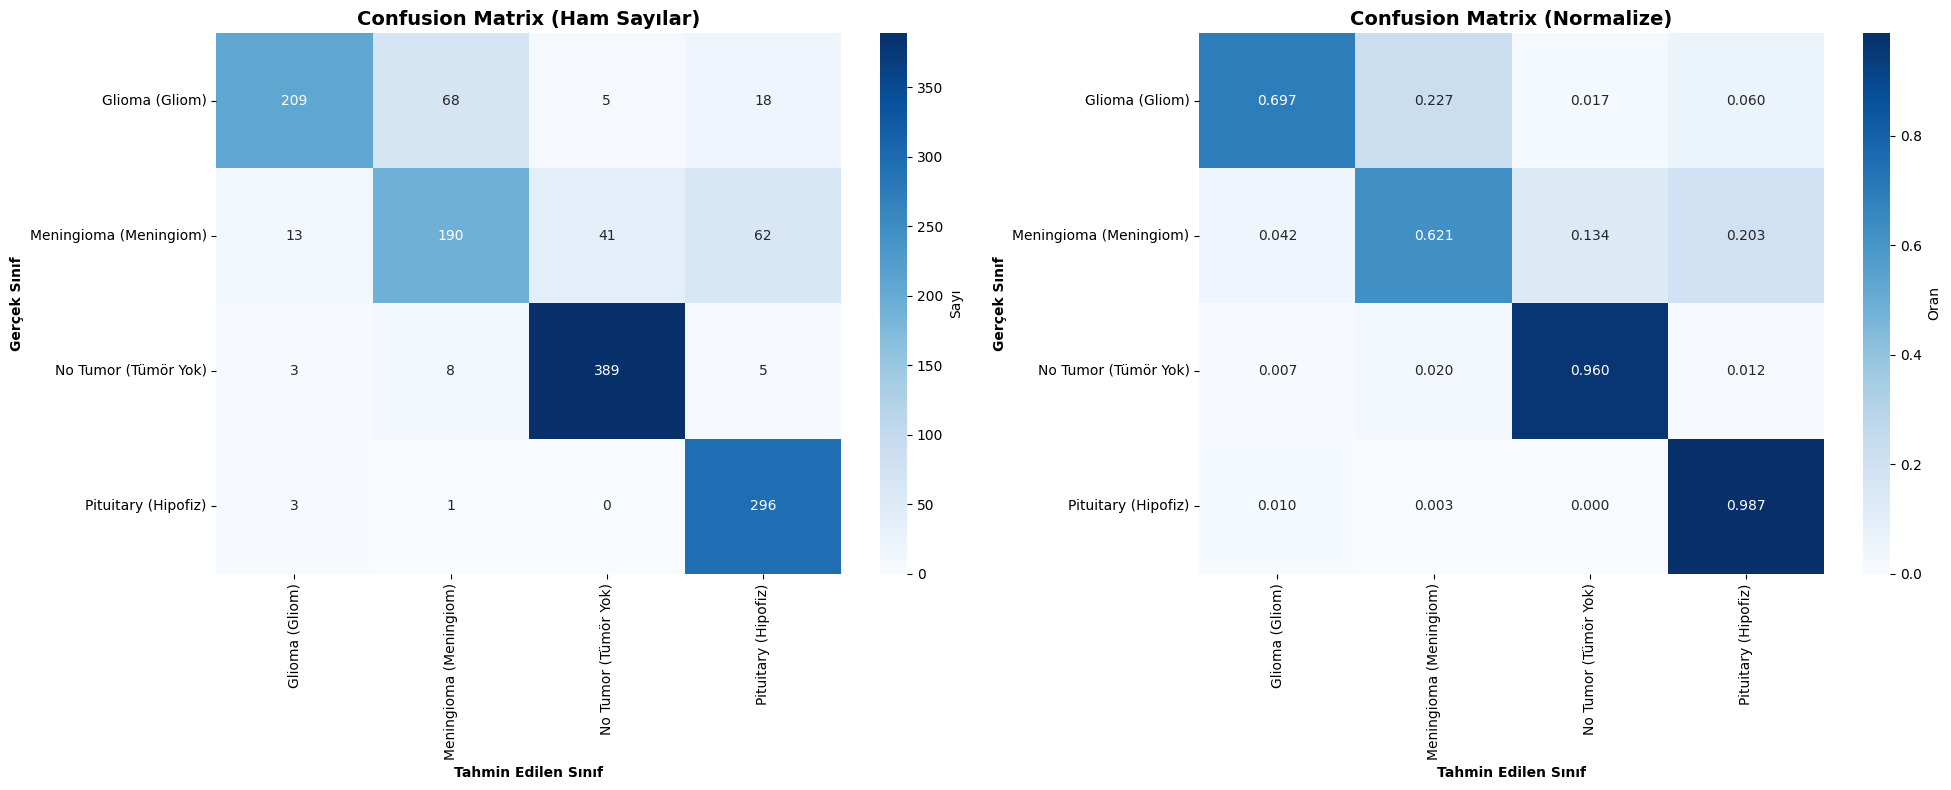


🎯 SINIF BAZINDA ACCURACY
----------------------------------------
Glioma (Gliom)           : 0.6967 (69.67%)
Meningioma (Meningiom)   : 0.6209 (62.09%)
No Tumor (Tümör Yok)     : 0.9605 (96.05%)
Pituitary (Hipofiz)      : 0.9867 (98.67%)


In [10]:
# =============================================================================
# CONFUSION MATRIX GÖRSELLEŞTİRMESİ
# =============================================================================

def plot_confusion_matrix(cm, class_labels):
    """Confusion matrix'i görselleştirir"""
    
    # Sınıf isimlerini Türkçe'ye çevir
    turkish_labels = [CLASS_LABELS[name] for name in class_labels]
    
    # Normalize edilmiş confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Subplot oluştur
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Ham confusion matrix
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=turkish_labels,
        yticklabels=turkish_labels,
        ax=axes[0],
        cbar_kws={'label': 'Sayı'}
    )
    axes[0].set_title('Confusion Matrix (Ham Sayılar)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Tahmin Edilen Sınıf', fontweight='bold')
    axes[0].set_ylabel('Gerçek Sınıf', fontweight='bold')
    
    # Normalize edilmiş confusion matrix
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt='.3f', 
        cmap='Blues',
        xticklabels=turkish_labels,
        yticklabels=turkish_labels,
        ax=axes[1],
        cbar_kws={'label': 'Oran'}
    )
    axes[1].set_title('Confusion Matrix (Normalize)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Tahmin Edilen Sınıf', fontweight='bold')
    axes[1].set_ylabel('Gerçek Sınıf', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Sınıf bazında accuracy hesaplama
    class_accuracies = cm_normalized.diagonal()
    print("\n🎯 SINIF BAZINDA ACCURACY")
    print("-" * 40)
    for i, (label, acc) in enumerate(zip(turkish_labels, class_accuracies)):
        print(f"{label:<25}: {acc:.4f} ({acc*100:.2f}%)")

# Confusion matrix görselleştirme
plot_confusion_matrix(cm, class_labels)


✅ Analiz için kullanılacak son konvolüsyon katmanı: block5_conv3
✅ Örnek resim yolları otomatik olarak bulunuyor...
✅ Analiz için 4 örnek bulundu.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


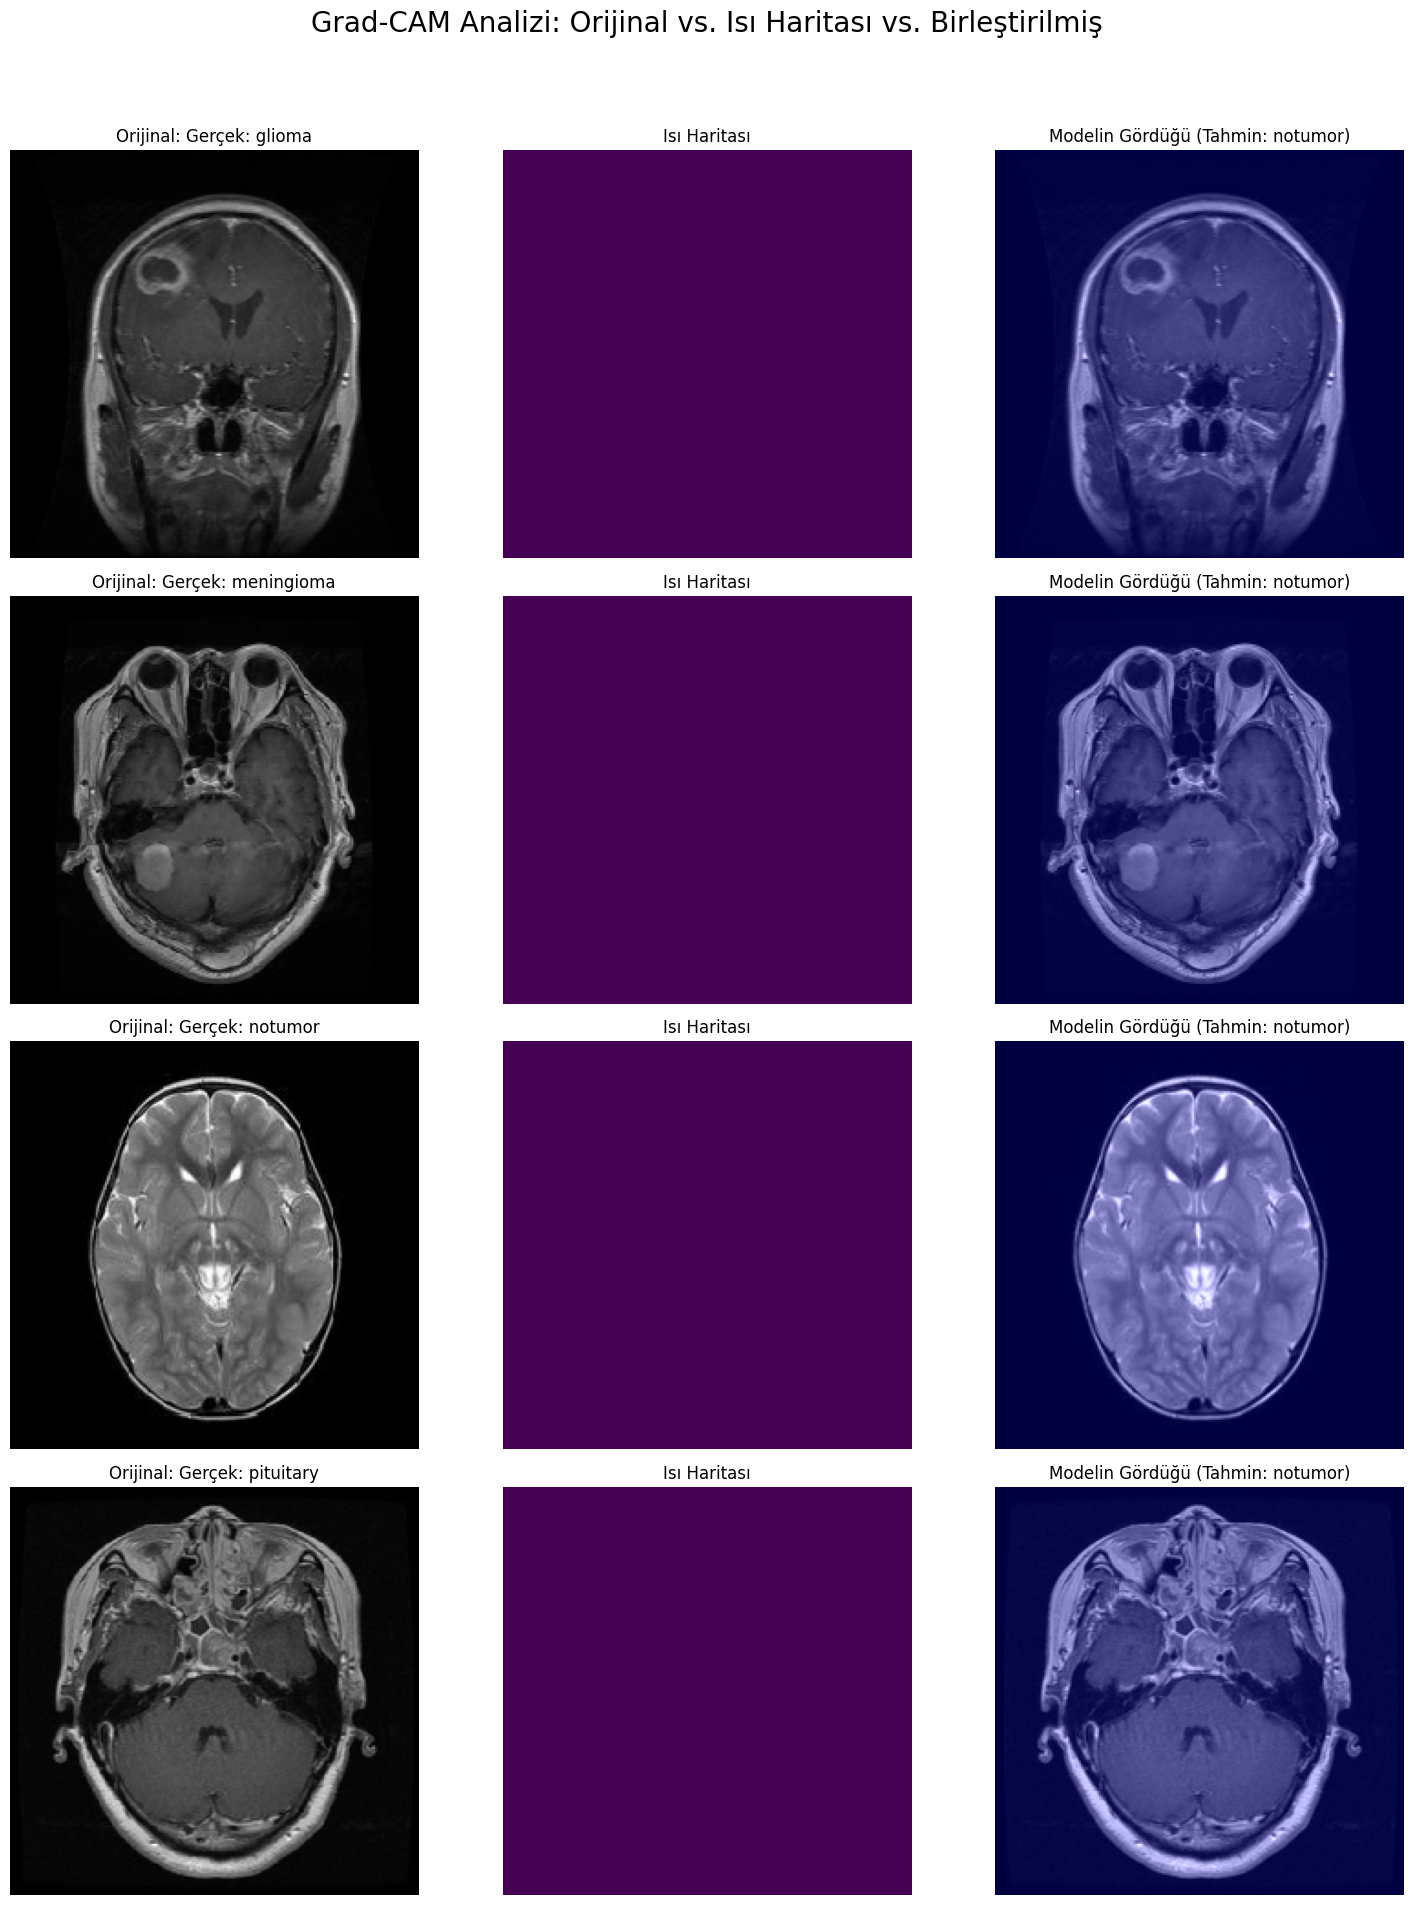

In [11]:
# =================================================================
# # Grad-CAM Analizi - Model Hangi Bölgelere Odaklanıyor? 
# =================================================================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# --- GEREKLİ DEĞİŞKENLER ---
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BASE_PATH = '/kaggle/input/brain-tumor-mri-dataset'
TEST_DIR = os.path.join(BASE_PATH, 'Testing')

# --- Grad-CAM Fonksiyonları  ---

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

def analyze_gradcam_samples(sample_images, model, last_conv_layer_name, class_labels):
    num_samples = len(sample_images)
    if num_samples == 0:
        print("Analiz edilecek örnek resim bulunamadı.")
        return
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    fig.suptitle('Grad-CAM Analizi: Orijinal vs. Isı Haritası vs. Birleştirilmiş', fontsize=20)
    for i, (img_path, title) in enumerate(sample_images):
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array_expanded = np.expand_dims(img_array, axis=0)
        preds = model.predict(img_array_expanded)
        pred_class_index = np.argmax(preds[0])
        pred_class_label = class_labels[pred_class_index]
        heatmap = get_gradcam_heatmap(img_array_expanded, model, last_conv_layer_name, pred_class_index)
        superimposed_img = save_and_display_gradcam(img_path, heatmap)
        superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
        axes[i, 0].imshow(img); axes[i, 0].set_title(f"Orijinal: {title}", fontsize=12); axes[i, 0].axis('off')
        axes[i, 1].imshow(heatmap, cmap='viridis'); axes[i, 1].set_title("Isı Haritası", fontsize=12); axes[i, 1].axis('off')
        axes[i, 2].imshow(superimposed_img); axes[i, 2].set_title(f"Modelin Gördüğü (Tahmin: {pred_class_label})", fontsize=12); axes[i, 2].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- Analizi Başlat ---

last_conv_layer_name = None
for layer in model.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name:
    print(f"✅ Analiz için kullanılacak son konvolüsyon katmanı: {last_conv_layer_name}")

    # --- OTOMATİK YOL BULUCU ---
    sample_images = []
    if 'class_labels' in locals() and os.path.exists(TEST_DIR):
        print("✅ Örnek resim yolları otomatik olarak bulunuyor...")
        for label in class_labels:
            try:
                # Her sınıfa ait klasörü bul
                class_dir = os.path.join(TEST_DIR, label)
                # Klasördeki ilk resmi bul
                first_image = os.listdir(class_dir)[0]
                # Tam yolunu oluştur ve listeye ekle
                image_path = os.path.join(class_dir, first_image)
                sample_images.append((image_path, f"Gerçek: {label}"))
            except (FileNotFoundError, IndexError):
                print(f"⚠️ Uyarı: '{label}' sınıfı için örnek resim bulunamadı veya klasör yolu yanlış.")
                continue
    else:
        print("Hata: 'class_labels' bulunamadı veya TEST_DIR yolu geçersiz. Lütfen önceki hücreleri çalıştırın.")

    # --- Analizi Çalıştır ---
    if sample_images:
        print(f"✅ Analiz için {len(sample_images)} örnek bulundu.")
        analyze_gradcam_samples(sample_images, model, last_conv_layer_name, class_labels)
    else:
        print("❌ Analiz başlatılamadı, hiçbir örnek resim bulunamadı.")
else:
    print("❌ Modelde hiçbir konvolüsyon katmanı bulunamadı.")


In [12]:
# =============================================================================
# HİPERPARAMETRE OPTİMİZASYONU
# =============================================================================

def hyperparameter_tuning():
    """Hiperparametre optimizasyonu için Keras Tuner kullanır"""
    
    try:
        import keras_tuner as kt
        
        def build_model(hp):
            """Hiperparametre optimizasyonu için model oluşturur"""
            
            model = models.Sequential()
            
            # Input layer
            model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS)))
            
            # Convolutional layers
            for i in range(hp.Int('num_conv_blocks', 2, 4)):
                model.add(layers.Conv2D(
                    filters=hp.Choice(f'conv_{i}_filters', [32, 64, 128, 256]),
                    kernel_size=hp.Choice(f'conv_{i}_kernel', [3, 5]),
                    activation='relu',
                    padding='same'
                ))
                model.add(layers.BatchNormalization())
                model.add(layers.MaxPooling2D((2, 2)))
                model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))
            
            # Global pooling
            model.add(layers.GlobalAveragePooling2D())
            
            # Dense layers
            for i in range(hp.Int('num_dense_layers', 1, 3)):
                model.add(layers.Dense(
                    units=hp.Choice(f'dense_{i}_units', [128, 256, 512, 1024]),
                    activation='relu'
                ))
                model.add(layers.BatchNormalization())
                model.add(layers.Dropout(hp.Float(f'dense_dropout_{i}', 0.3, 0.7, step=0.1)))
            
            # Output layer
            model.add(layers.Dense(4, activation='softmax'))
            
            # Compile
            model.compile(
                optimizer=optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            
            return model
        
        # Tuner oluştur
        tuner = kt.RandomSearch(
            build_model,
            objective='val_accuracy',
            max_trials=10,
            directory='hyperparameter_tuning',
            project_name='brain_tumor_classification'
        )
        
        # Tuning yap
        tuner.search(
            train_gen,
            epochs=10,
            validation_data=val_gen,
            callbacks=[EarlyStopping(patience=3)]
        )
        
        # En iyi hiperparametreleri al
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        
        print("🎯 EN İYİ HİPERPARAMETRELER")
        print("=" * 40)
        for param, value in best_hps.values.items():
            print(f"{param}: {value}")
        
        return best_hps
        
    except ImportError:
        print("⚠️ Keras Tuner yüklü değil. Manuel hiperparametre optimizasyonu yapılacak.")
        return None

# Hiperparametre optimizasyonu (opsiyonel)
# best_hyperparameters = hyperparameter_tuning()


In [13]:
# =================================================================
# # MODEL VE SONUÇLAR KAYDEDİLİYOR 
# =================================================================
import json
import pandas as pd

def save_model_and_results(model, history, predictions, class_labels):
    """
    Modeli, ağırlıkları, mimariyi ve sonuçları kaydeder.
    """
    print("\n💾 MODEL VE SONUÇLAR KAYDEDİLİYOR...")
    print("=" * 50)

    
    model.save('brain_tumor_classification_model.keras')
    print("✅ Modelin tamamı 'brain_tumor_classification_model.keras' olarak kaydedildi.")

    # 2. Sadece ağırlıkları kaydet (Yeni standart ile)
    #    Dosya adı '.weights.h5' ile bitmeli.
    model.save_weights('brain_tumor_classification.weights.h5')
    print("✅ Model ağırlıkları 'brain_tumor_classification.weights.h5' olarak kaydedildi.")

    # 3. Model mimarisini JSON olarak kaydet
    model_json = model.to_json()
    with open('brain_tumor_model_architecture.json', 'w') as json_file:
        json_file.write(model_json)
    print("✅ Model mimarisi 'brain_tumor_model_architecture.json' olarak kaydedildi.")

    # 4. Eğitim geçmişini (history) kaydet
    history_df = pd.DataFrame(history.history)
    history_df.to_csv('training_history.csv', index=False)
    print("✅ Eğitim geçmişi 'training_history.csv' olarak kaydedildi.")
    
    print("\n🎉 Tüm kaydetme işlemleri başarıyla tamamlandı!")


# --- Fonksiyonu Çalıştır ---
if 'predictions' in locals() and 'class_labels' in locals():
    save_model_and_results(model, history, predictions, class_labels)
else:
    print("❌ Hata: 'predictions' veya 'class_labels' bulunamadı. Lütfen 'Değerlendirme' hücresini çalıştırın.")




💾 MODEL VE SONUÇLAR KAYDEDİLİYOR...
✅ Modelin tamamı 'brain_tumor_classification_model.keras' olarak kaydedildi.
✅ Model ağırlıkları 'brain_tumor_classification.weights.h5' olarak kaydedildi.
✅ Model mimarisi 'brain_tumor_model_architecture.json' olarak kaydedildi.
✅ Eğitim geçmişi 'training_history.csv' olarak kaydedildi.

🎉 Tüm kaydetme işlemleri başarıyla tamamlandı!


In [14]:
# =============================================================================
# YENİ GÖRÜNTÜLER İÇİN TAHMİN FONKSİYONU
# =============================================================================

def predict_brain_tumor(image_path, model, class_mapping):
    """Yeni bir MRI görüntüsü için tümör tahmini yapar"""
    
    # Görüntüyü yükle ve ön işle
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    # Tahmin yap
    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    # Sonuçları formatla
    result = {
        'predicted_class': class_mapping[predicted_class],
        'confidence': float(confidence),
        'all_probabilities': {
            class_mapping[i]: float(prob) 
            for i, prob in enumerate(predictions[0])
        }
    }
    
    return result

def visualize_prediction(image_path, result):
    """Tahmin sonucunu görselleştirir"""
    
    # Görüntüyü yükle
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Subplot oluştur
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Orijinal görüntü
    axes[0].imshow(img)
    axes[0].set_title('MRI Görüntüsü', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Tahmin sonuçları
    classes = list(result['all_probabilities'].keys())
    probabilities = list(result['all_probabilities'].values())
    
    colors = ['red' if cls == result['predicted_class'] else 'lightblue' for cls in classes]
    
    bars = axes[1].bar(classes, probabilities, color=colors)
    axes[1].set_title(f'Tahmin Sonuçları\nEn Yüksek: {result["predicted_class"]} ({result["confidence"]:.3f})', 
                     fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Olasılık')
    axes[1].set_ylim(0, 1)
    
    # Bar değerlerini göster
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Sonucu yazdır
    print(f"\n🎯 TAHMİN SONUCU")
    print("=" * 40)
    print(f"Tahmin Edilen Sınıf: {result['predicted_class']}")
    print(f"Güven Skoru: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
    print(f"\n📊 Tüm Sınıf Olasılıkları:")
    for cls, prob in result['all_probabilities'].items():
        print(f"  {cls:<25}: {prob:.4f} ({prob*100:.2f}%)")

# Örnek kullanım
# Sınıf mapping'i oluştur
class_mapping = {i: CLASS_LABELS[label] for i, label in enumerate(class_labels)}

# Test görüntüsü üzerinde örnek tahmin
test_image_path = f"{TESTING_PATH}/glioma/Te-gl_0001.jpg"  # Örnek dosya
if os.path.exists(test_image_path):
    result = predict_brain_tumor(test_image_path, model, class_mapping)
    visualize_prediction(test_image_path, result)


In [15]:
# =============================================================================
# DETAYLI PERFORMANS ANALİZİ
# =============================================================================

def detailed_performance_analysis(true_classes, pred_classes, predictions, class_labels):
    """Detaylı performans analizi yapar"""
    
    from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
    from sklearn.preprocessing import label_binarize
    
    print("📈 DETAYLI PERFORMANS ANALİZİ")
    print("=" * 50)
    
    # Sınıf bazında metrikler
    precision, recall, f1, support = precision_recall_fscore_support(
        true_classes, pred_classes, average=None
    )
    
    # Sonuçları tablo halinde göster
    results_df = pd.DataFrame({
        'Sınıf': [CLASS_LABELS[label] for label in class_labels],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    print("\n📋 Sınıf Bazında Metrikler:")
    print(results_df.round(4))
    
    # Macro ve Weighted averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        true_classes, pred_classes, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        true_classes, pred_classes, average='weighted'
    )
    
    print(f"\n📊 Genel Metrikler:")
    print(f"Macro Avg - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Avg - Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    
    # ROC-AUC hesaplama (multi-class)
    y_true_bin = label_binarize(true_classes, classes=range(len(class_labels)))
    
    # Her sınıf için ROC-AUC
    roc_auc_scores = []
    for i in range(len(class_labels)):
        try:
            auc = roc_auc_score(y_true_bin[:, i], predictions[:, i])
            roc_auc_scores.append(auc)
        except:
            roc_auc_scores.append(0.0)
    
    print(f"\n🎯 ROC-AUC Skorları:")
    for label, auc in zip([CLASS_LABELS[label] for label in class_labels], roc_auc_scores):
        print(f"  {label:<25}: {auc:.4f}")
    
    # Ortalama ROC-AUC
    avg_roc_auc = np.mean(roc_auc_scores)
    print(f"  {'Ortalama ROC-AUC':<25}: {avg_roc_auc:.4f}")
    
    return results_df

performance_df = detailed_performance_analysis(true_classes, pred_classes, predictions, class_labels)


📈 DETAYLI PERFORMANS ANALİZİ

📋 Sınıf Bazında Metrikler:
                    Sınıf  Precision  Recall  F1-Score  Support
0          Glioma (Gliom)     0.9167  0.6967    0.7917      300
1  Meningioma (Meningiom)     0.7116  0.6209    0.6632      306
2    No Tumor (Tümör Yok)     0.8943  0.9605    0.9262      405
3     Pituitary (Hipofiz)     0.7769  0.9867    0.8693      300

📊 Genel Metrikler:
Macro Avg - Precision: 0.8249, Recall: 0.8162, F1: 0.8126
Weighted Avg - Precision: 0.8299, Recall: 0.8268, F1: 0.8210

🎯 ROC-AUC Skorları:
  Glioma (Gliom)           : 0.9634
  Meningioma (Meningiom)   : 0.9136
  No Tumor (Tümör Yok)     : 0.9878
  Pituitary (Hipofiz)      : 0.9934
  Ortalama ROC-AUC         : 0.9646


In [16]:
# =============================================================================
# DEPLOYMENT HAZIRLIĞI
# =============================================================================

def create_deployment_package():
    """Deployment için gerekli dosyaları hazırlar"""
    
    print("🚀 DEPLOYMENT PAKETİ HAZIRLANIYOR...")
    
    # Requirements.txt oluştur
    requirements = """
tensorflow==2.13.0
numpy==1.24.3
opencv-python==4.8.0.74
pillow==10.0.0
matplotlib==3.7.1
seaborn==0.12.2
scikit-learn==1.3.0
pandas==2.0.3
plotly==5.15.0
"""
    
    with open('requirements.txt', 'w') as f:
        f.write(requirements.strip())
    
    inference_script = '''
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pickle

class BrainTumorClassifier:
    def __init__(self, model_path, class_mapping_path):
        self.model = tf.keras.models.load_model(model_path)
        with open(class_mapping_path, 'rb') as f:
            self.class_mapping = pickle.load(f)
        self.img_size = 224
    
    def predict(self, image_path):
        # Görüntüyü ön işle
        img = load_img(image_path, target_size=(self.img_size, self.img_size))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        
        # Tahmin yap
        predictions = self.model.predict(img_array, verbose=0)
        predicted_class = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        
        return {
            'predicted_class': self.class_mapping[predicted_class],
            'confidence': float(confidence),
            'all_probabilities': {
                self.class_mapping[i]: float(prob) 
                for i, prob in enumerate(predictions[0])
            }
        }

# Kullanım örneği:
# classifier = BrainTumorClassifier('brain_tumor_classification_model.h5', 'class_mapping.pkl')
# result = classifier.predict('path/to/mri/image.jpg')
# print(result)
'''
    
    with open('inference.py', 'w') as f:
        f.write(inference_script)
    
    # Docker dosyası oluştur
    dockerfile = '''
FROM tensorflow/tensorflow:2.13.0

WORKDIR /app

COPY requirements.txt .
RUN pip install -r requirements.txt

COPY . .

EXPOSE 8000

CMD ["python", "app.py"]
'''
    
    with open('Dockerfile', 'w') as f:
        f.write(dockerfile)
    
    print("✅ Deployment dosyaları oluşturuldu!")
    print("📁 Oluşturulan dosyalar:")
    print("   - requirements.txt")
    print("   - inference.py") 
    print("   - Dockerfile")

create_deployment_package()


🚀 DEPLOYMENT PAKETİ HAZIRLANIYOR...
✅ Deployment dosyaları oluşturuldu!
📁 Oluşturulan dosyalar:
   - requirements.txt
   - inference.py
   - Dockerfile


In [17]:
# =================================================================
# # FİNAL RAPOR 
# =================================================================
import pandas as pd

def generate_final_report(history, test_accuracy):
    """
    Eğitim geçmişi ve test doğruluğunu kullanarak özet bir rapor oluşturur.
    """
    print("\n\n" + "="*60)
    print("🏆 FİNAL PROJE RAPORU 🏆")
    print("="*60)

    # En iyi epoch'u bul
    best_epoch = np.argmin(history.history['val_loss']) + 1
    best_val_loss = np.min(history.history['val_loss'])
    best_val_acc = history.history['val_accuracy'][best_epoch - 1]

    print("\n--- EĞİTİM ÖZETİ ---")
    print(f"🔹 Toplam Epoch Sayısı (Early Stopping ile): {len(history.history['loss'])}")
    print(f"🔹 En İyi Epoch: {best_epoch}")
    print(f"🔹 En Düşük Validation Loss: {best_val_loss:.4f}")
    print(f"🔹 En İyi Epoch'taki Validation Accuracy: {best_val_acc*100:.2f}%")

    print("\n--- FİNAL TEST PERFORMANSI ---")
    print(f"⭐ Modelin Test Veri Setindeki Nihai Doğruluğu: {test_accuracy*100:.2f}%")
    
    print("\n--- GENEL DEĞERLENDİRME ---")
    if test_accuracy > 0.80:
        print("✅ Model, %80'in üzerinde bir test doğruluğu ile başarılı bir performans sergilemiştir.")
    elif test_accuracy > 0.70:
        print("⚠️ Model, kabul edilebilir bir performans göstermiştir ancak iyileştirme potansiyeli bulunmaktadır.")
    else:
        print("❌ Modelin performansı düşüktür ve iyileştirilmesi gerekmektedir.")
        
    print("\n" + "="*60)
    print("🎉 PROJE BAŞARIYLA TAMAMLANDI! 🎉")
    print("="*60)


generate_final_report(history, test_accuracy)




🏆 FİNAL PROJE RAPORU 🏆

--- EĞİTİM ÖZETİ ---
🔹 Toplam Epoch Sayısı (Early Stopping ile): 23
🔹 En İyi Epoch: 18
🔹 En Düşük Validation Loss: 0.5314
🔹 En İyi Epoch'taki Validation Accuracy: 79.67%

--- FİNAL TEST PERFORMANSI ---
⭐ Modelin Test Veri Setindeki Nihai Doğruluğu: 82.68%

--- GENEL DEĞERLENDİRME ---
✅ Model, %80'in üzerinde bir test doğruluğu ile başarılı bir performans sergilemiştir.

🎉 PROJE BAŞARIYLA TAMAMLANDI! 🎉


✅ Model '/kaggle/input/brain-tumor-classification-model-keras/brain_tumor_classification_model.keras' dosyasından başarıyla yüklendi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


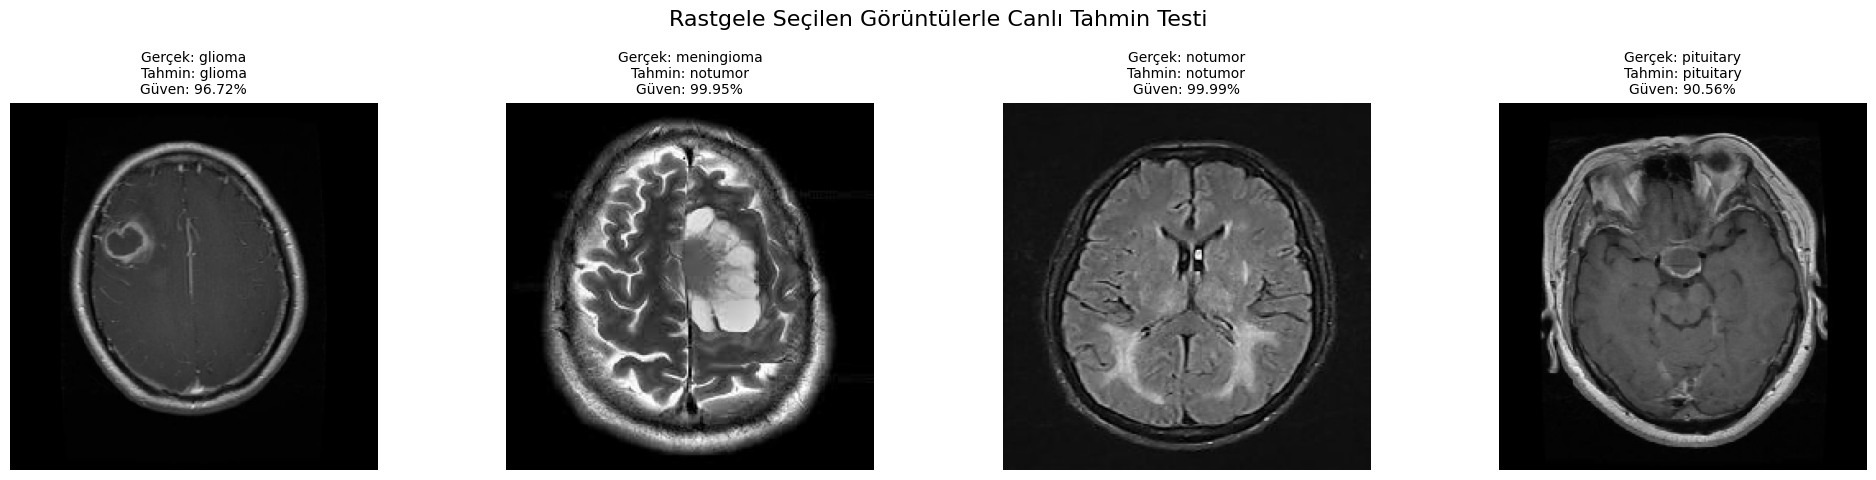

In [18]:
# =================================================================
# # CANLI TAHMİN TESTİ: Model Gerçekten Biliyor mu? 
# =================================================================
import tensorflow as tf
import random
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)


MODEL_PATH = '/kaggle/input/brain-tumor-classification-model-keras/brain_tumor_classification_model.keras'

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"✅ Model '{MODEL_PATH}' dosyasından başarıyla yüklendi.")
except Exception as e:
    print(f"❌ HATA: Model yüklenemedi. Yolu kontrol edin. Hata: {e}")
    model = None


TEST_DIR = '/kaggle/input/brain-tumor-mri-dataset/Testing'
if 'class_labels' not in locals():
    class_labels = sorted(os.listdir(TEST_DIR))

if model is not None:
    fig, axes = plt.subplots(1, len(class_labels), figsize=(20, 5))
    fig.suptitle('Rastgele Seçilen Görüntülerle Canlı Tahmin Testi', fontsize=16)
    for i, label in enumerate(class_labels):
        try:
            class_path = os.path.join(TEST_DIR, label)
            image_files = os.listdir(class_path)
            random_image_name = random.choice(image_files)
            img_path = os.path.join(class_path, random_image_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0
            prediction = model.predict(img_array_expanded)
            predicted_class_index = np.argmax(prediction[0])
            predicted_class_label = class_labels[predicted_class_index]
            confidence = np.max(prediction[0]) * 100
            ax = axes[i]
            ax.imshow(img)
            ax.set_title(f"Gerçek: {label}\nTahmin: {predicted_class_label}\nGüven: {confidence:.2f}%", fontsize=10)
            ax.axis('off')
            if label == predicted_class_label:
                plt.setp(ax.spines.values(), color='green', linewidth=3)
            else:
                plt.setp(ax.spines.values(), color='red', linewidth=3)
        except (FileNotFoundError, IndexError):
            axes[i].set_title(f"{label} için resim bulunamadı.")
            axes[i].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
